In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Scale-Free and High Clustering Properties Analysis

This notebook explores the relationship between logit graph parameters and two key network properties:
1. **Clustering coefficient**: Measures the degree to which nodes tend to cluster together
2. **Scale-free property**: Tests if the degree distribution follows a power-law (characteristic of scale-free networks)

## Parameter Space

We perform a parameter sweep on:
- **σ (sigma)**: Intercept parameter controlling baseline edge probability [-10, 10]
- **d**: Neighborhood depth [0, 1, 2] - controls how many hops to consider for degree calculations
- **α = β = 1.0**: Fixed symmetric weights (not varied in this experiment)
- **n = 500**: Network size

In [29]:
import sys
import os
sys.path.append('..')

# Graph imports
from src.logit_graph import simulation, graph, utils
import src.logit_graph.graph as graph_module

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## Helper Functions for Analysis

In [30]:
def calculate_clustering_coefficient(G):
    """
    Calculate average clustering coefficient for a graph.
    """
    if G.number_of_nodes() == 0 or G.number_of_edges() == 0:
        return 0.0
    return nx.average_clustering(G)


def test_power_law_fit(G, method='ks'):
    """
    Test if degree distribution follows a power-law distribution.
    
    Returns:
        dict: Contains power_law_alpha (exponent), ks_statistic, p_value, and is_scale_free (bool)
    """
    if G.number_of_nodes() == 0 or G.number_of_edges() == 0:
        return {
            'power_law_alpha': np.nan,
            'ks_statistic': np.nan,
            'p_value': 0.0,
            'is_scale_free': False,
            'min_degree': 0,
            'max_degree': 0
        }
    
    degrees = [d for n, d in G.degree() if d > 0]
    
    if len(degrees) < 10:  # Need minimum sample size
        return {
            'power_law_alpha': np.nan,
            'ks_statistic': np.nan,
            'p_value': 0.0,
            'is_scale_free': False,
            'min_degree': min(degrees) if degrees else 0,
            'max_degree': max(degrees) if degrees else 0
        }
    
    # Fit power law using log-log linear regression
    degree_counts = np.bincount(degrees)
    non_zero_degrees = np.where(degree_counts > 0)[0]
    
    if len(non_zero_degrees) < 3:
        return {
            'power_law_alpha': np.nan,
            'ks_statistic': np.nan,
            'p_value': 0.0,
            'is_scale_free': False,
            'min_degree': min(degrees),
            'max_degree': max(degrees)
        }
    
    x = non_zero_degrees
    y = degree_counts[non_zero_degrees]
    
    # Log-log linear regression
    log_x = np.log(x)
    log_y = np.log(y)
    
    # Fit line
    slope, intercept = np.polyfit(log_x, log_y, 1)
    power_law_alpha = -slope  # Convert slope to power-law exponent
    
    # Calculate goodness of fit using KS test
    # Generate expected power-law distribution
    expected_powerlaw = x ** slope * np.exp(intercept)
    expected_powerlaw = expected_powerlaw / expected_powerlaw.sum()
    observed = y / y.sum()
    
    # Kolmogorov-Smirnov test
    ks_stat = np.max(np.abs(np.cumsum(observed) - np.cumsum(expected_powerlaw)))
    
    # Rough p-value estimation (for reference)
    # A proper p-value would require bootstrapping
    n_samples = len(degrees)
    p_value = np.exp(-2 * n_samples * ks_stat**2)
    
    # Consider scale-free if KS statistic is low and alpha is in typical range (2-3)
    is_scale_free = (ks_stat < 0.15) and (2.0 < power_law_alpha < 4.0)
    
    return {
        'power_law_alpha': power_law_alpha,
        'ks_statistic': ks_stat,
        'p_value': p_value,
        'is_scale_free': is_scale_free,
        'min_degree': min(degrees),
        'max_degree': max(degrees)
    }


def analyze_graph_properties(G):
    """
    Comprehensive analysis of graph properties.
    """
    clustering = calculate_clustering_coefficient(G)
    power_law_results = test_power_law_fit(G)
    
    return {
        'n_nodes': G.number_of_nodes(),
        'n_edges': G.number_of_edges(),
        'density': nx.density(G),
        'avg_degree': 2 * G.number_of_edges() / G.number_of_nodes() if G.number_of_nodes() > 0 else 0,
        'clustering_coefficient': clustering,
        **power_law_results
    }

## Parameter Sweep Experiment

In [ ]:
def run_parameter_sweep(n=100, n_iterations=5000, patience=1000, n_repeats=3, warm_up=20, er_p=0.001):
    """
    Run parameter sweep over sigma, d, and alpha/beta values.
    
    Args:
        n: Number of nodes
        n_iterations: Maximum iterations for graph generation
        patience: Patience for convergence
        n_repeats: Number of repetitions for each parameter combination
    """
    # Define parameter ranges
    sigma_values = [-10, -5, -1, -0.5]
    d_values = [0, 1, 2]  # Neighborhood depth
    alpha_beta_pairs = [
        (1.0, 1.0),  # Symmetric
    ]
    
    results = []
    
    total_experiments = len(sigma_values) * len(d_values) * len(alpha_beta_pairs) * n_repeats
    
    with tqdm(total=total_experiments, desc="Running parameter sweep") as pbar:
        for sigma in sigma_values:
            for d in d_values:
                for alpha, beta in alpha_beta_pairs:
                    for repeat in range(n_repeats):
                        try:
                            # Create and simulate logit graph
                            sim = simulation.LogitGraphSimulation(
                                n=n,
                                d=d,
                                sigma=sigma,
                                alpha=alpha,
                                beta=beta,
                                er_p=er_p,
                                n_iteration=n_iterations,
                                warm_up=warm_up,
                                patience=patience,
                                verbose=False
                            )
                            
                            sim.simulate()

                            # Plot the graph and degree distribution side by side
                            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
                            
                            # Plot the graph with improved layout
                            pos = nx.spring_layout(sim.simulated_graph, k=0.5, iterations=50, seed=42)
                            
                            # Calculate node sizes based on degree
                            degrees = dict(sim.simulated_graph.degree())
                            node_sizes = [100 + 20 * degrees[node] for node in sim.simulated_graph.nodes()]
                            
                            # Draw nodes with size based on degree
                            nx.draw_networkx_nodes(
                                sim.simulated_graph, 
                                pos, 
                                node_size=node_sizes,
                                node_color='#1f77b4',
                                alpha=0.7,
                                ax=ax1
                            )
                            
                            # Draw edges with transparency
                            nx.draw_networkx_edges(
                                sim.simulated_graph,
                                pos,
                                alpha=0.2,
                                width=0.5,
                                ax=ax1
                            )
                            
                            ax1.set_title(f'Graph Structure (n={n}, edges={sim.simulated_graph.number_of_edges()})', 
                                         fontsize=12, fontweight='bold')
                            ax1.axis('off')
                            
                            # Plot the degree distribution with improved styling
                            degree_sequence = [degree for node, degree in sim.simulated_graph.degree()]
                            
                            # Use bars instead of histogram for better control
                            degree_counts = pd.Series(degree_sequence).value_counts().sort_index()
                            
                            ax2.bar(degree_counts.index, degree_counts.values, 
                                   color='#1f77b4', alpha=0.7, edgecolor='black', linewidth=0.5)
                            
                            ax2.set_title('Degree Distribution', fontsize=12, fontweight='bold')
                            ax2.set_xlabel('Degree', fontsize=10)
                            ax2.set_ylabel('Count', fontsize=10)
                            ax2.grid(axis='y', alpha=0.3, linestyle='--')
                            
                            # Add statistics text
                            mean_degree = np.mean(degree_sequence)
                            max_degree = np.max(degree_sequence)
                            ax2.text(0.95, 0.95, 
                                    f'Mean: {mean_degree:.2f}\nMax: {max_degree}',
                                    transform=ax2.transAxes,
                                    verticalalignment='top',
                                    horizontalalignment='right',
                                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                                    fontsize=9)
                            
                            plt.tight_layout()
                            plt.show()

                            
                            if sim.simulated_graph is not None:
                                # Analyze properties
                                props = analyze_graph_properties(sim.simulated_graph)
                                
                                # Store results
                                result = {
                                    'sigma': sigma,
                                    'd': d,
                                    'alpha': alpha,
                                    'beta': beta,
                                    'repeat': repeat,
                                    **props
                                }
                                results.append(result)
                        
                        except Exception as e:
                            print(f"Error with sigma={sigma}, d={d}, alpha={alpha}, beta={beta}, repeat={repeat}: {e}")
                        
                        pbar.update(1)
    
    return pd.DataFrame(results)

## Run the Experiment

⚠️ **Note**: This may take several minutes to complete depending on your system.

Running parameter sweep:   0%|          | 0/6 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/2000 [00:00<?, ?it/s]

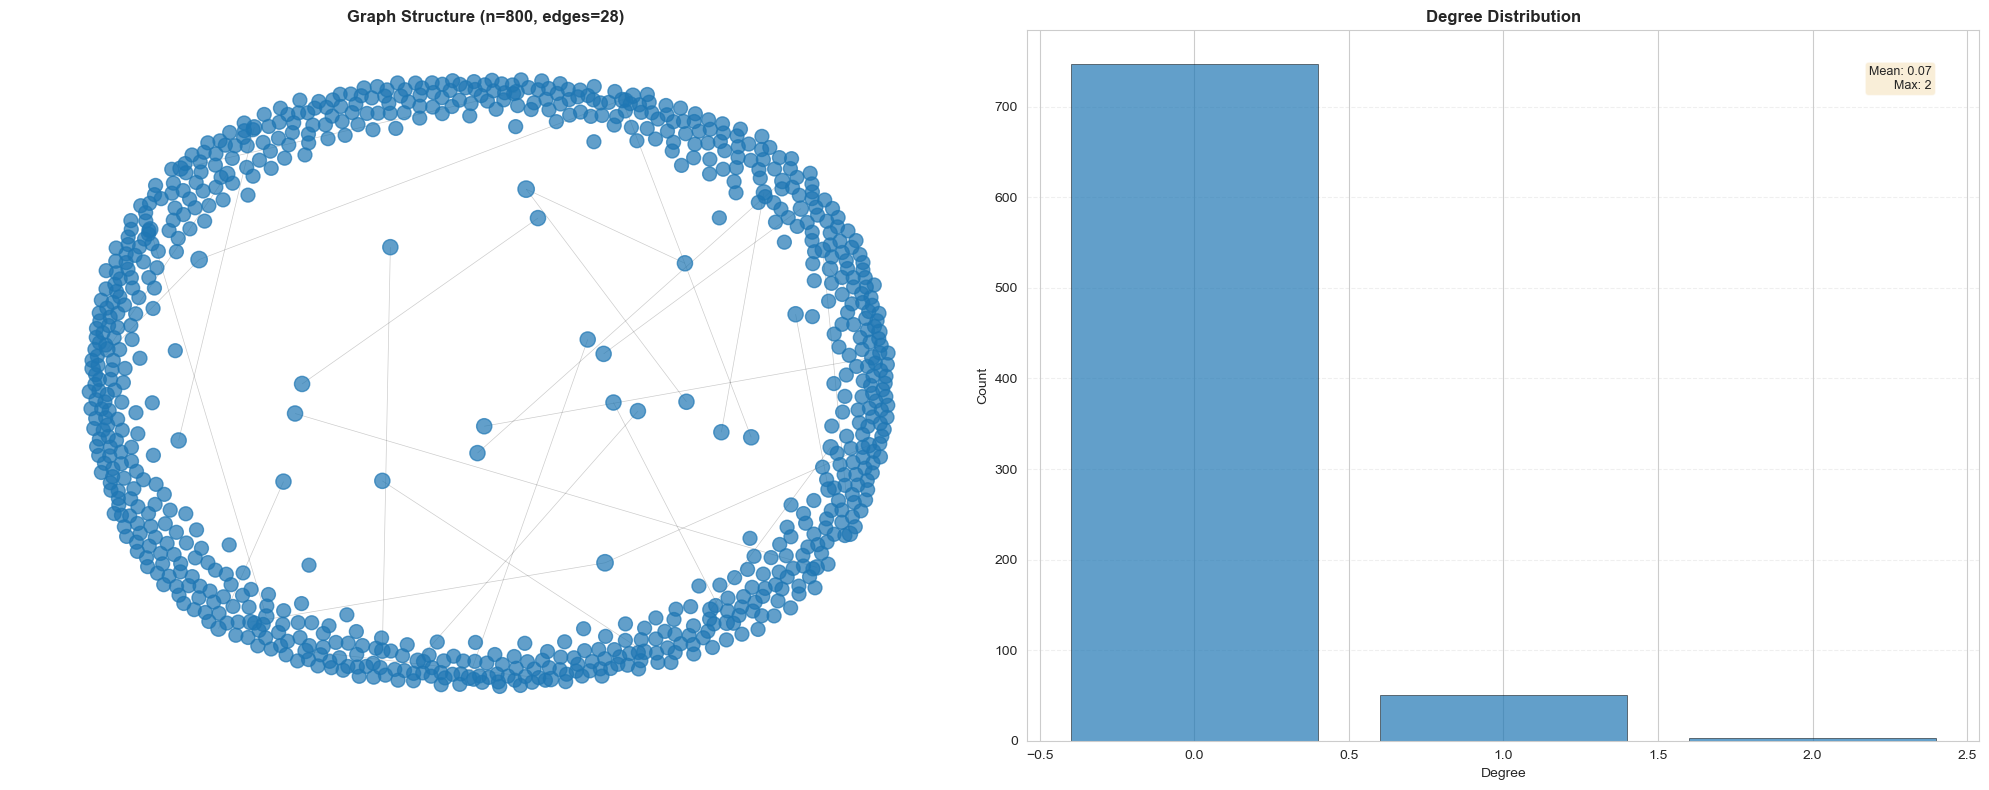

Running parameter sweep:  17%|█▋        | 1/6 [00:06<00:34,  6.86s/it]

Generating graph:   0%|          | 0/2000 [00:00<?, ?it/s]

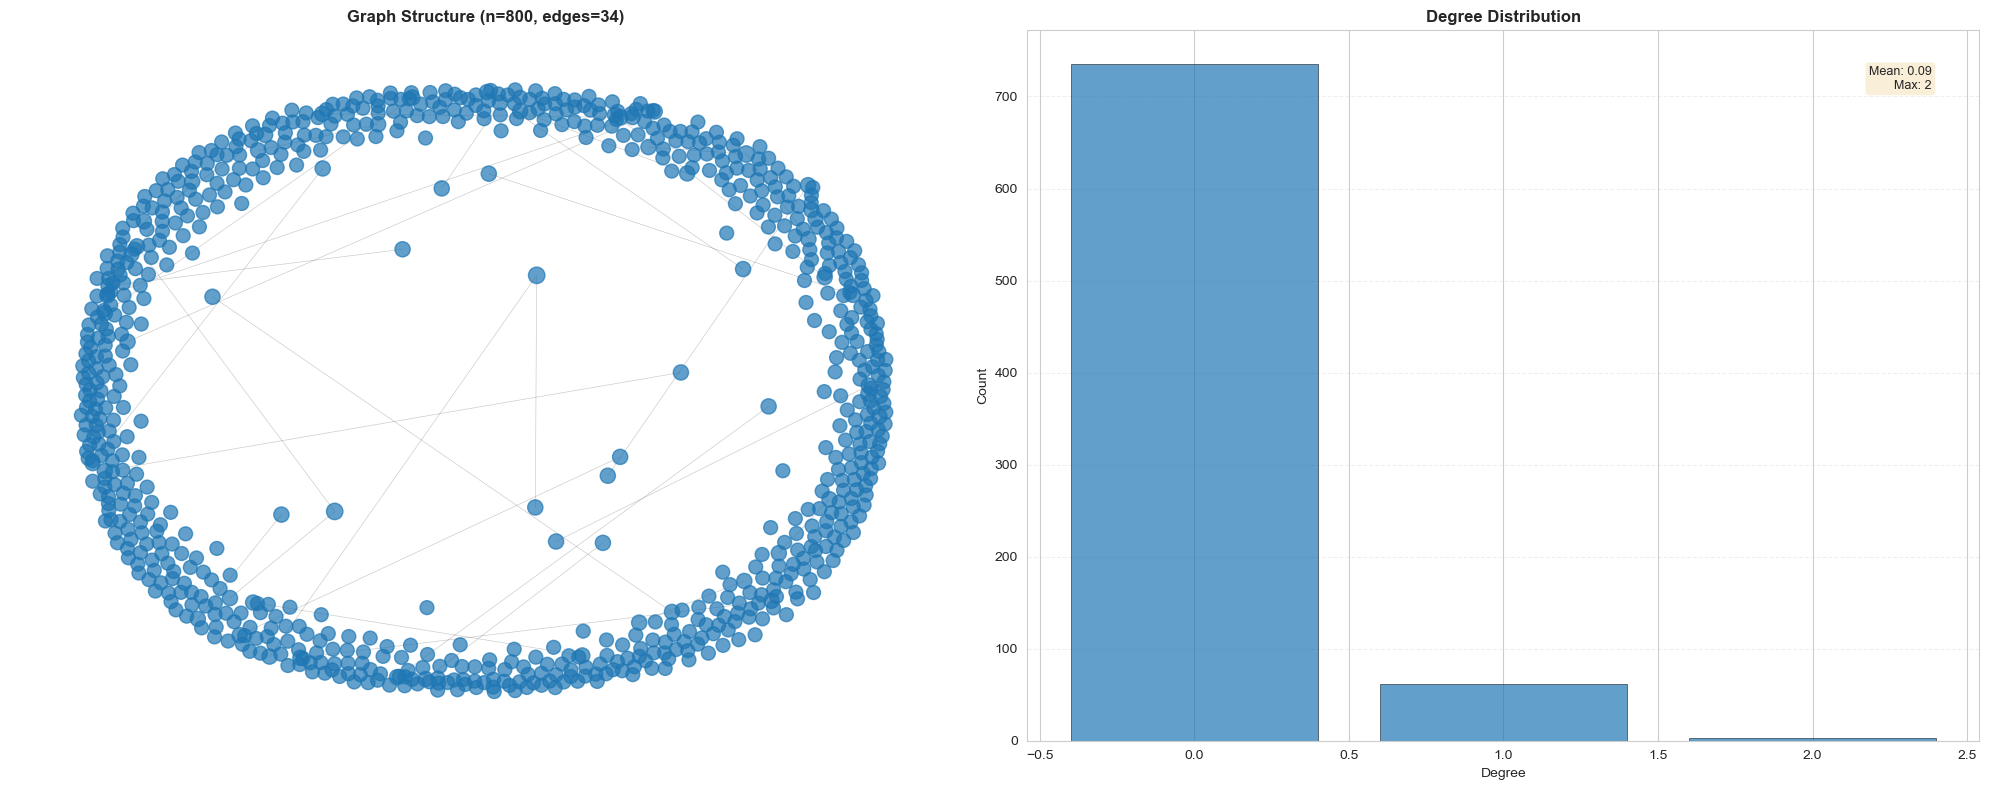

Running parameter sweep:  33%|███▎      | 2/6 [00:13<00:27,  6.87s/it]

Generating graph:   0%|          | 0/2000 [00:00<?, ?it/s]

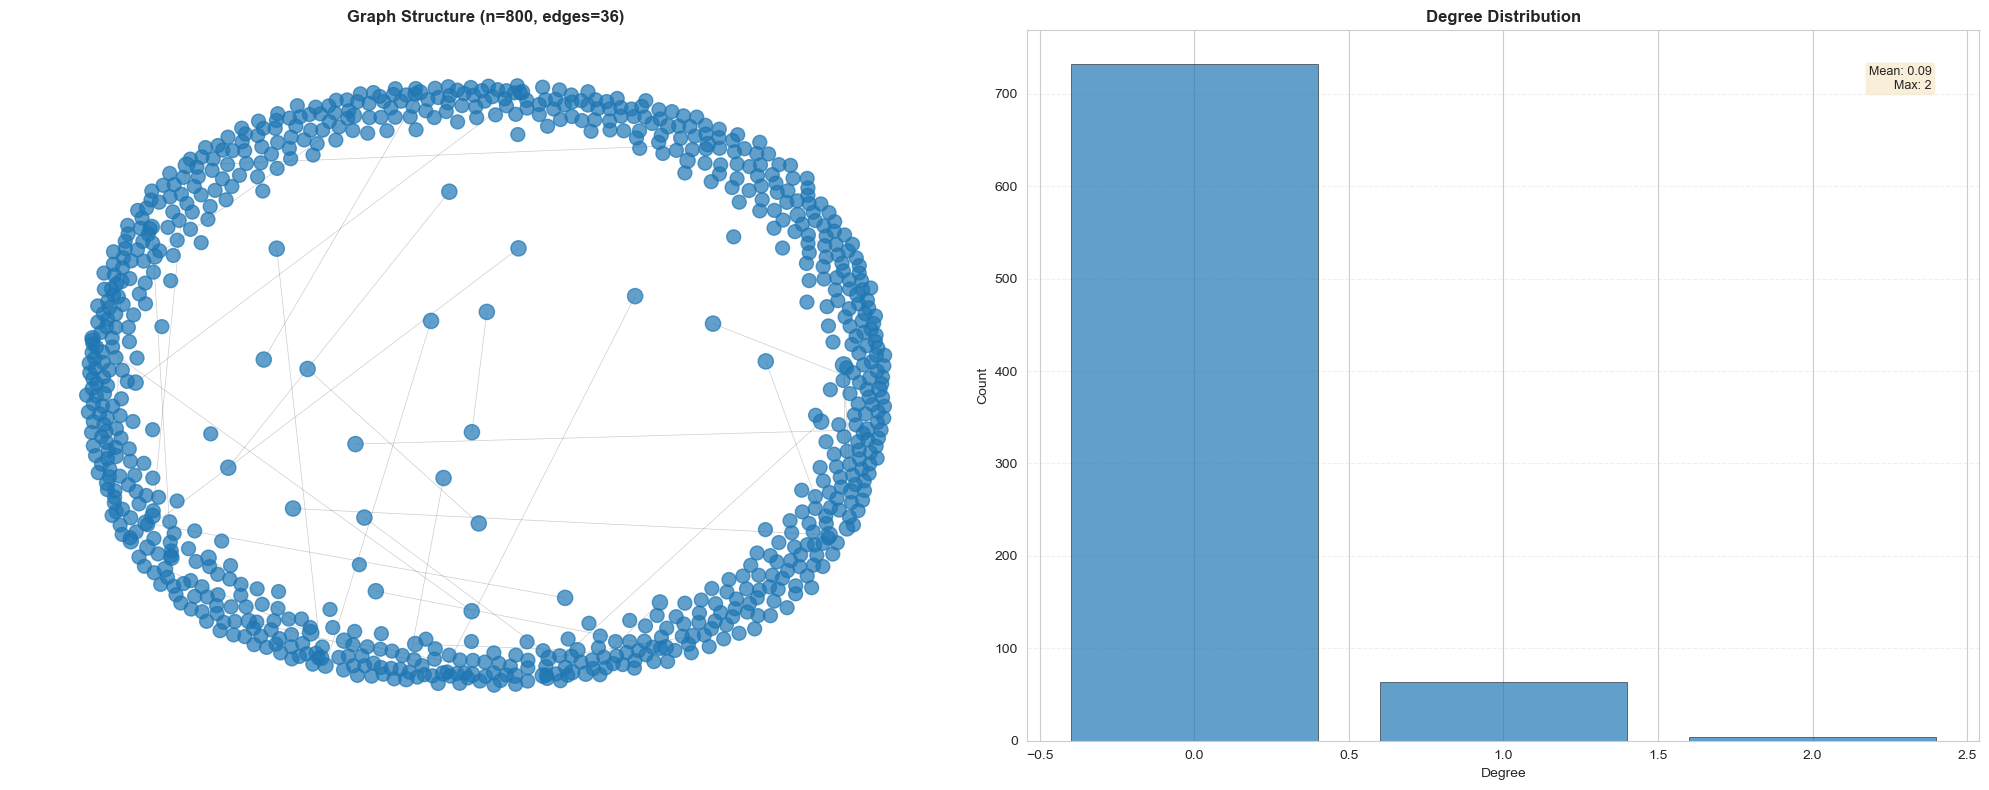

Running parameter sweep:  50%|█████     | 3/6 [00:21<00:21,  7.13s/it]

Generating graph:   0%|          | 0/2000 [00:00<?, ?it/s]

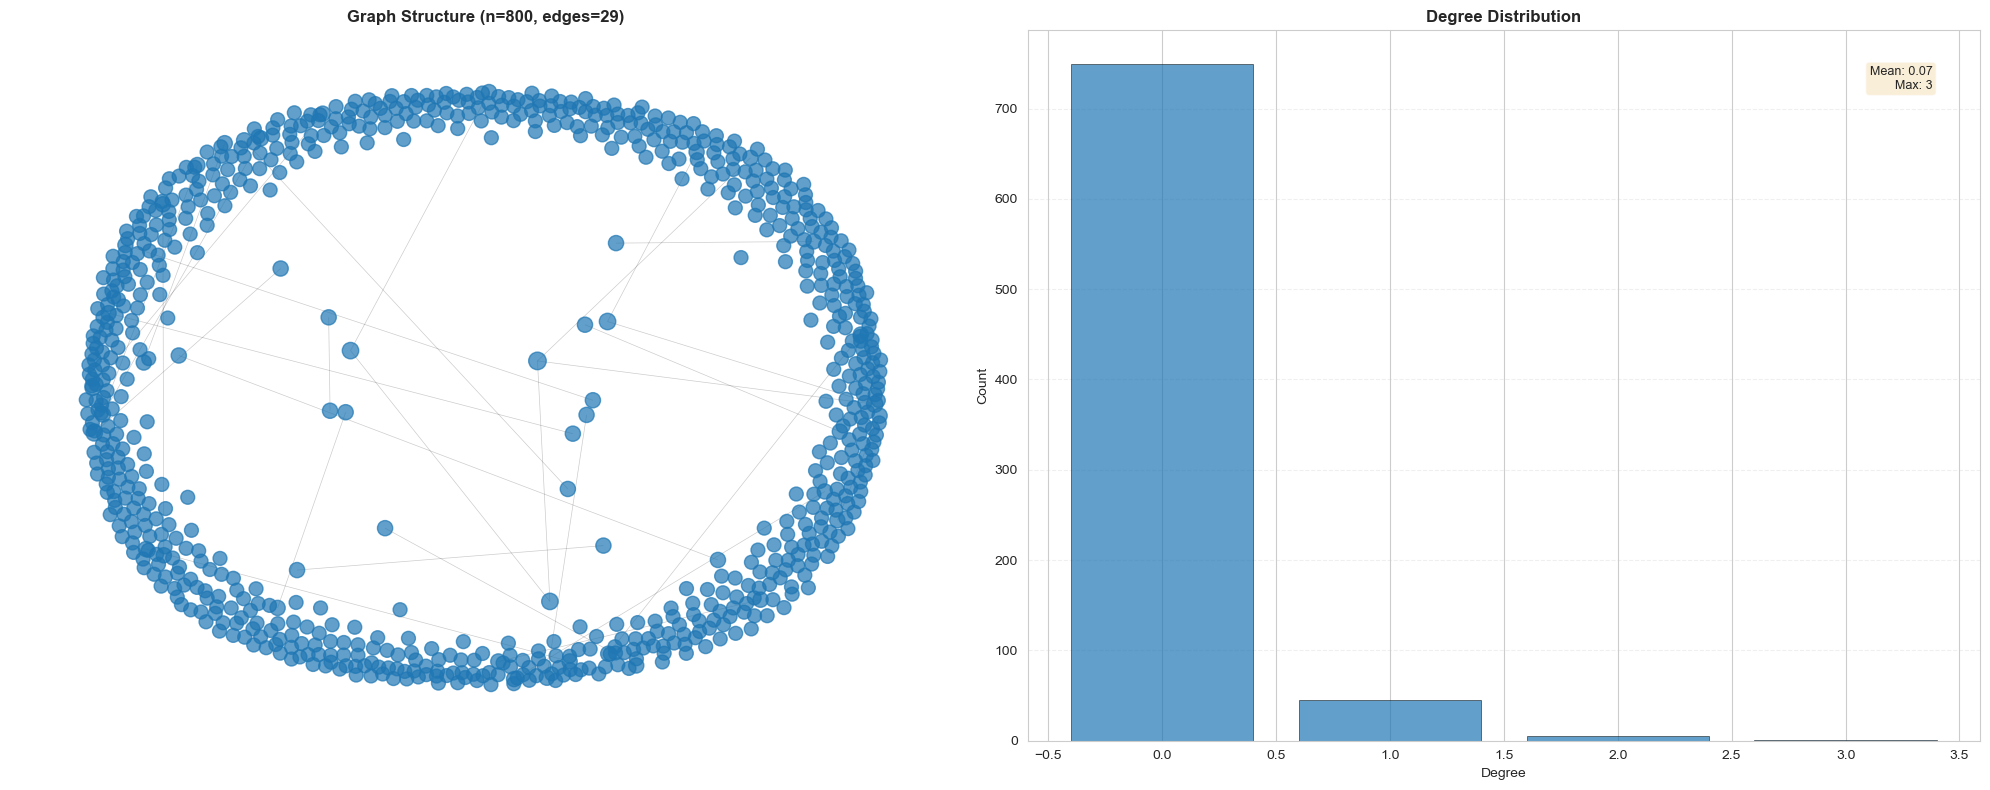

Running parameter sweep:  67%|██████▋   | 4/6 [00:28<00:14,  7.29s/it]

Generating graph:   0%|          | 0/2000 [00:00<?, ?it/s]

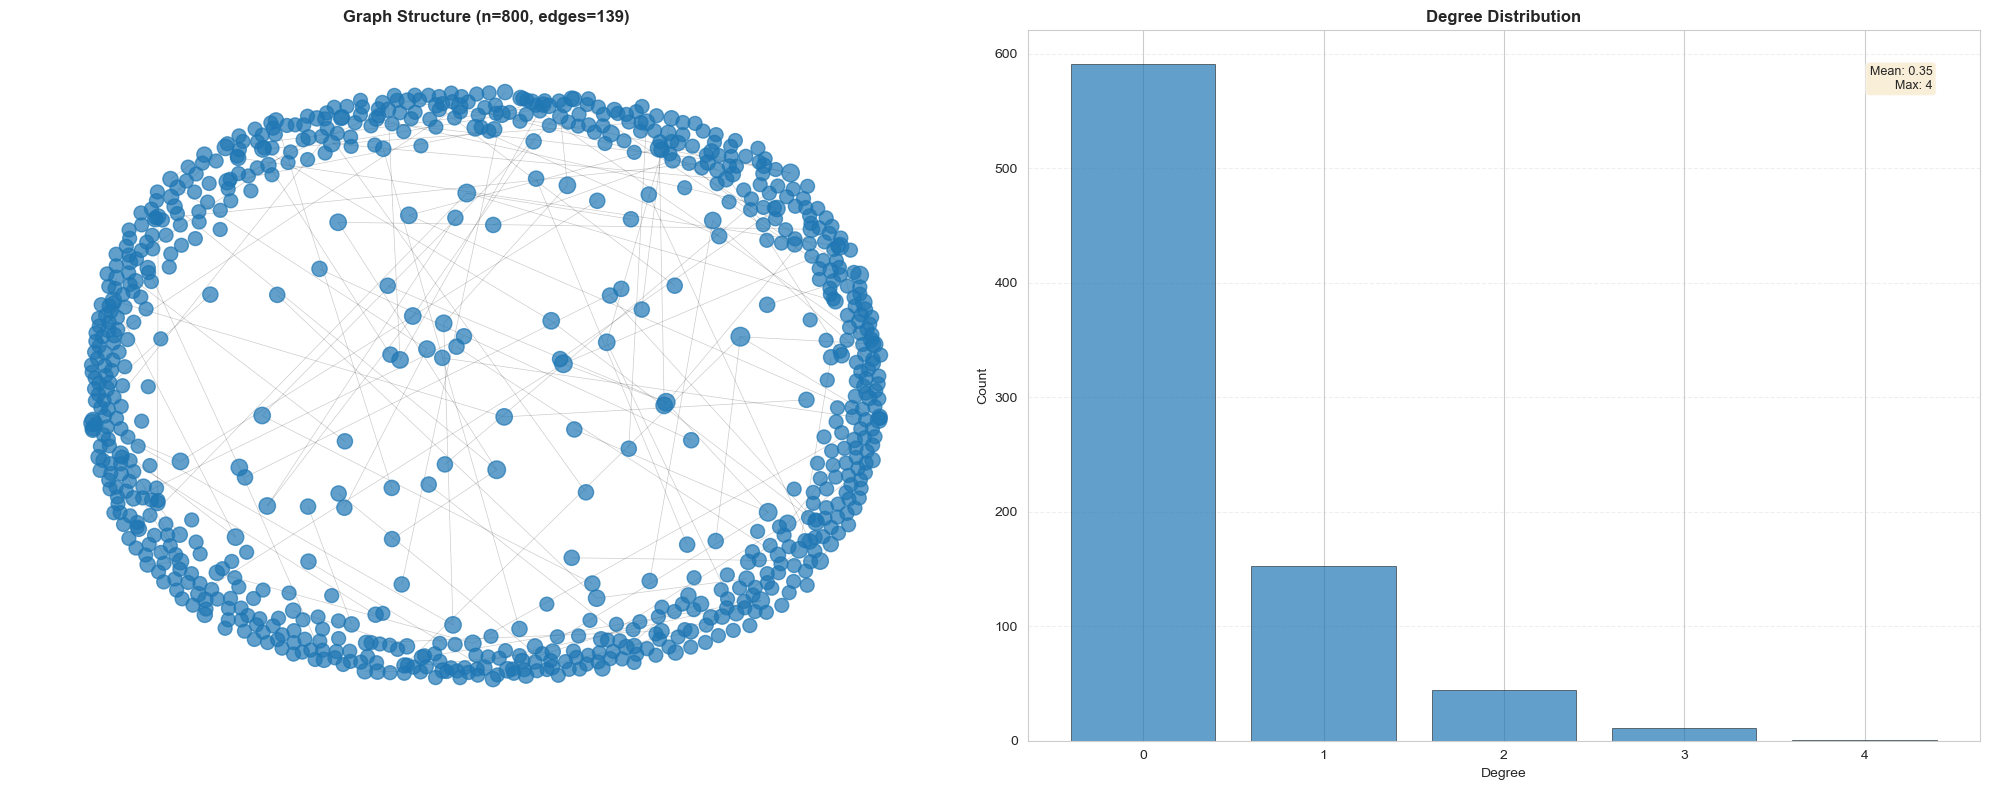

Running parameter sweep:  83%|████████▎ | 5/6 [00:35<00:07,  7.28s/it]

Generating graph:   0%|          | 0/2000 [00:00<?, ?it/s]

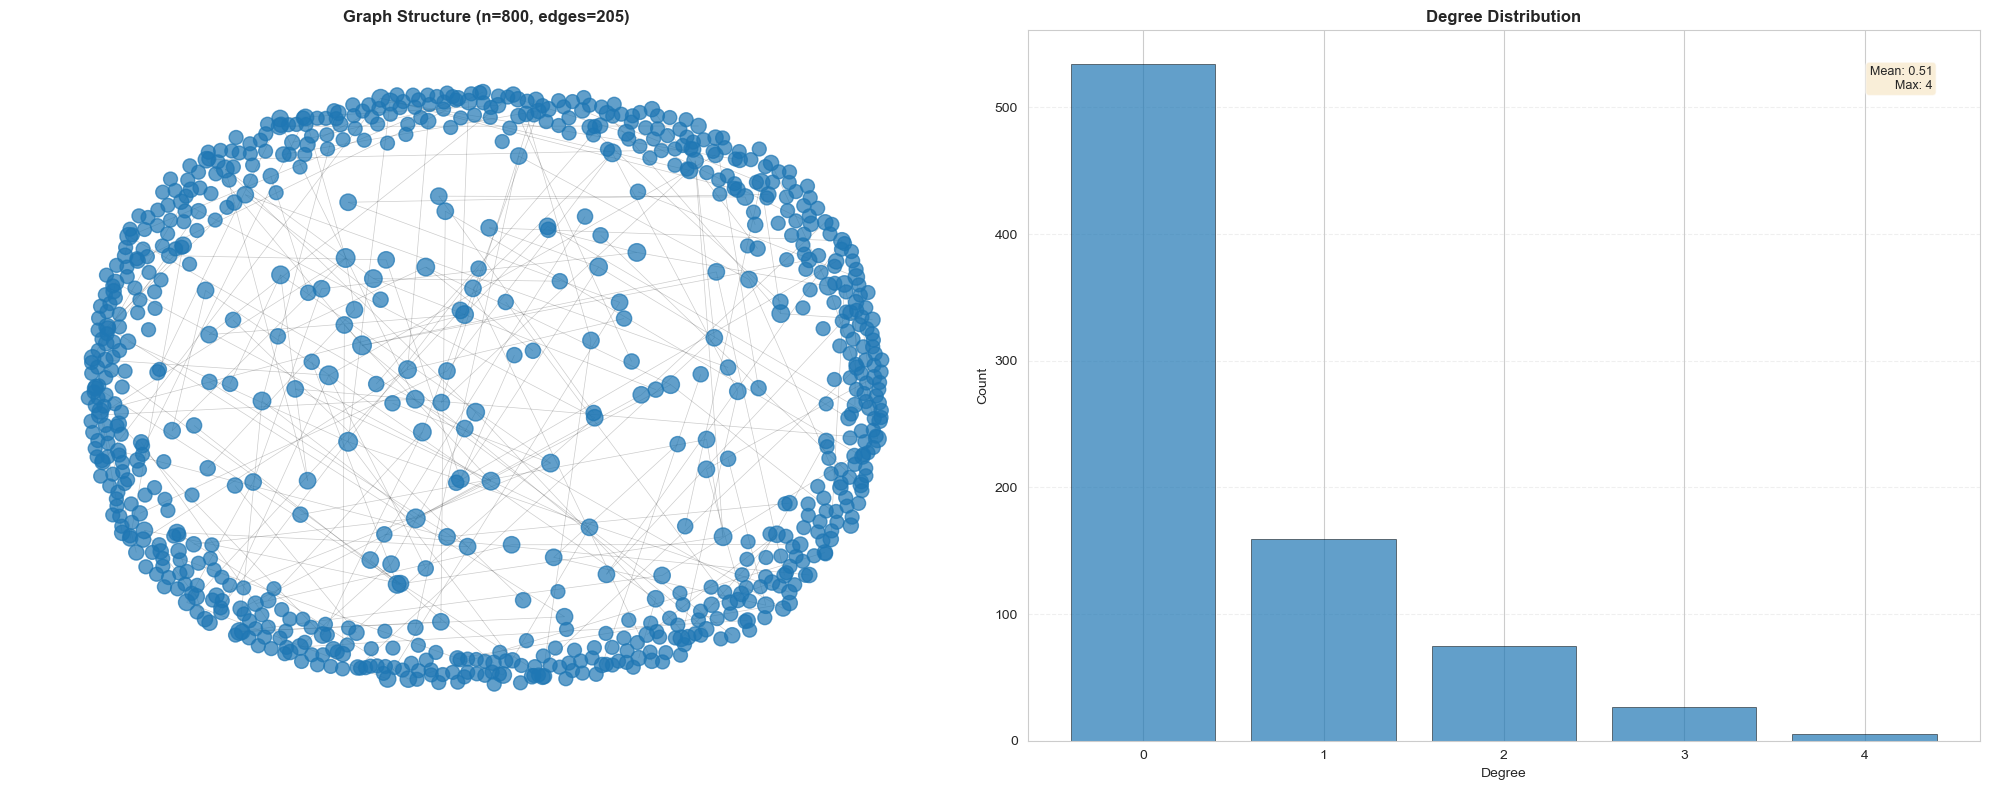

Running parameter sweep: 100%|██████████| 6/6 [00:44<00:00,  7.44s/it]

Collected 6 experiments

Sample results:
   sigma  d  alpha  beta  repeat  n_nodes  n_edges   density  avg_degree  \
0    -10  0    1.0   1.0       0      800       28  0.000088      0.0700   
1    -10  1    1.0   1.0       0      800       34  0.000106      0.0850   
2     -5  0    1.0   1.0       0      800       36  0.000113      0.0900   
3     -5  1    1.0   1.0       0      800       29  0.000091      0.0725   
4     -1  0    1.0   1.0       0      800      139  0.000435      0.3475   

   clustering_coefficient  power_law_alpha  ks_statistic   p_value  \
0                     0.0              NaN           NaN  0.000000   
1                     0.0              NaN           NaN  0.000000   
2                     0.0              NaN           NaN  0.000000   
3                     0.0         3.433202      0.014035  0.980109   
4                     0.0         3.367568      0.152112  0.000063   

   is_scale_free  min_degree  max_degree  
0          False           1          

In [33]:
# Run the parameter swee
results_df = run_parameter_sweep(
    n=800,
    n_iterations=2000,
    warm_up=300,
    er_p=0.0001,
    patience=100,
    n_repeats=1
)

In [35]:
# Save results
results_df.to_csv('scale_free_clustering_sweep_results.csv', index=False)
print(f"Collected {len(results_df)} experiments")
print(f"\nSample results:")
print(results_df.head())

# Display summary statistics
print("\n" + "="*80)
print("EXPERIMENT SUMMARY STATISTICS")
print("="*80)
print(f"\nTotal successful experiments: {len(results_df)}")
print(f"Sigma range: [{results_df['sigma'].min():.1f}, {results_df['sigma'].max():.1f}]")
print(f"d values: {sorted(results_df['d'].unique())}")
print(f"Alpha/Beta pairs: {list(results_df[['alpha', 'beta']].drop_duplicates().values)}")
print(f"\nClustering coefficient: {results_df['clustering_coefficient'].mean():.4f} ± {results_df['clustering_coefficient'].std():.4f}")
print(f"  Range: [{results_df['clustering_coefficient'].min():.4f}, {results_df['clustering_coefficient'].max():.4f}]")
print(f"\nScale-free proportion: {results_df['is_scale_free'].mean():.2%}")
print(f"Average degree: {results_df['avg_degree'].mean():.2f} ± {results_df['avg_degree'].std():.2f}")
print(f"Density: {results_df['density'].mean():.4f} ± {results_df['density'].std():.4f}")

Collected 6 experiments

Sample results:
   sigma  d  alpha  beta  repeat  n_nodes  n_edges   density  avg_degree  \
0    -10  0    1.0   1.0       0      800       28  0.000088      0.0700   
1    -10  1    1.0   1.0       0      800       34  0.000106      0.0850   
2     -5  0    1.0   1.0       0      800       36  0.000113      0.0900   
3     -5  1    1.0   1.0       0      800       29  0.000091      0.0725   
4     -1  0    1.0   1.0       0      800      139  0.000435      0.3475   

   clustering_coefficient  power_law_alpha  ks_statistic   p_value  \
0                     0.0              NaN           NaN  0.000000   
1                     0.0              NaN           NaN  0.000000   
2                     0.0              NaN           NaN  0.000000   
3                     0.0         3.433202      0.014035  0.980109   
4                     0.0         3.367568      0.152112  0.000063   

   is_scale_free  min_degree  max_degree  
0          False           1          

## Results Analysis and Visualization

In [36]:
# Aggregate results by parameter combinations (average over repeats)
agg_results = results_df.groupby(['sigma', 'd', 'alpha', 'beta']).agg({
    'clustering_coefficient': ['mean', 'std'],
    'power_law_alpha': ['mean', 'std'],
    'ks_statistic': ['mean', 'std'],
    'is_scale_free': 'mean',  # Proportion of times it was scale-free
    'avg_degree': 'mean',
    'density': 'mean',
    'n_edges': 'mean'
}).reset_index()

# Flatten column names
agg_results.columns = ['_'.join(col).strip('_') for col in agg_results.columns]

print(agg_results.head(10))

   sigma  d  alpha  beta  clustering_coefficient_mean  \
0    -10  0    1.0   1.0                          0.0   
1    -10  1    1.0   1.0                          0.0   
2     -5  0    1.0   1.0                          0.0   
3     -5  1    1.0   1.0                          0.0   
4     -1  0    1.0   1.0                          0.0   
5     -1  1    1.0   1.0                          0.0   

   clustering_coefficient_std  power_law_alpha_mean  power_law_alpha_std  \
0                         NaN                   NaN                  NaN   
1                         NaN                   NaN                  NaN   
2                         NaN                   NaN                  NaN   
3                         NaN              3.433202                  NaN   
4                         NaN              3.367568                  NaN   
5                         NaN              2.315300                  NaN   

   ks_statistic_mean  ks_statistic_std  is_scale_free_mean  avg_deg

### Plot 1: Main Results - Clustering Coefficient vs. Sigma

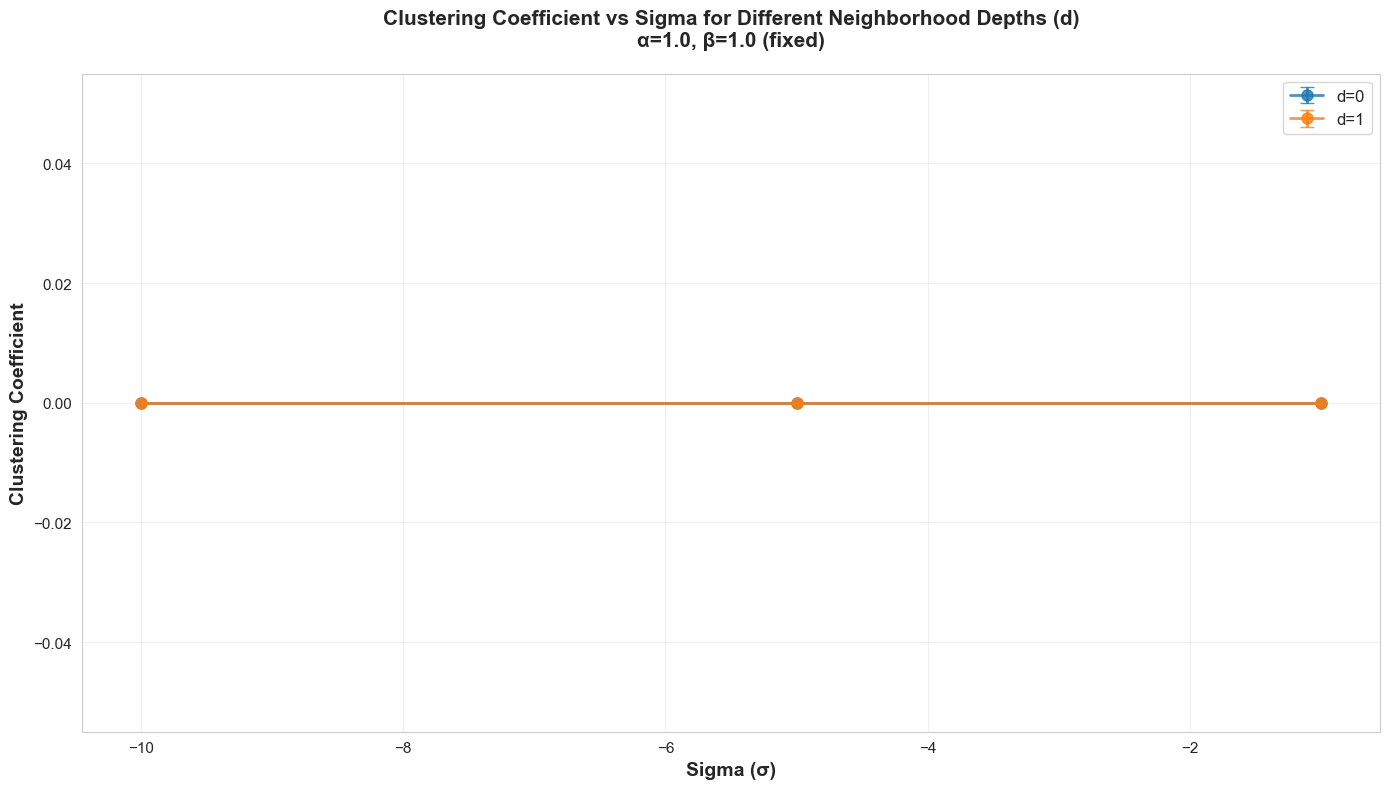


Clustering Statistics by d:

d=0:
  Mean: 0.0000
  Std: 0.0000
  Min: 0.0000
  Max: 0.0000

d=1:
  Mean: 0.0000
  Std: 0.0000
  Min: 0.0000
  Max: 0.0000


In [37]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Plot for each d value (alpha=1.0, beta=1.0 is fixed)
for d in sorted(agg_results['d'].unique()):
    d_data = agg_results[agg_results['d'] == d]
    ax.errorbar(
        d_data['sigma'],
        d_data['clustering_coefficient_mean'],
        yerr=d_data['clustering_coefficient_std'],
        marker='o',
        label=f'd={d}',
        capsize=5,
        alpha=0.8,
        linewidth=2,
        markersize=8
    )

ax.set_xlabel('Sigma (σ)', fontsize=14, fontweight='bold')
ax.set_ylabel('Clustering Coefficient', fontsize=14, fontweight='bold')
ax.set_title('Clustering Coefficient vs Sigma for Different Neighborhood Depths (d)\nα=1.0, β=1.0 (fixed)', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3)
ax.tick_params(labelsize=11)

plt.tight_layout()
plt.savefig('clustering_vs_sigma.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print("\nClustering Statistics by d:")
for d in sorted(agg_results['d'].unique()):
    d_data = agg_results[agg_results['d'] == d]
    print(f"\nd={d}:")
    print(f"  Mean: {d_data['clustering_coefficient_mean'].mean():.4f}")
    print(f"  Std: {d_data['clustering_coefficient_mean'].std():.4f}")
    print(f"  Min: {d_data['clustering_coefficient_mean'].min():.4f}")
    print(f"  Max: {d_data['clustering_coefficient_mean'].max():.4f}")

### Plot 2: Scale-Free Property vs. Sigma

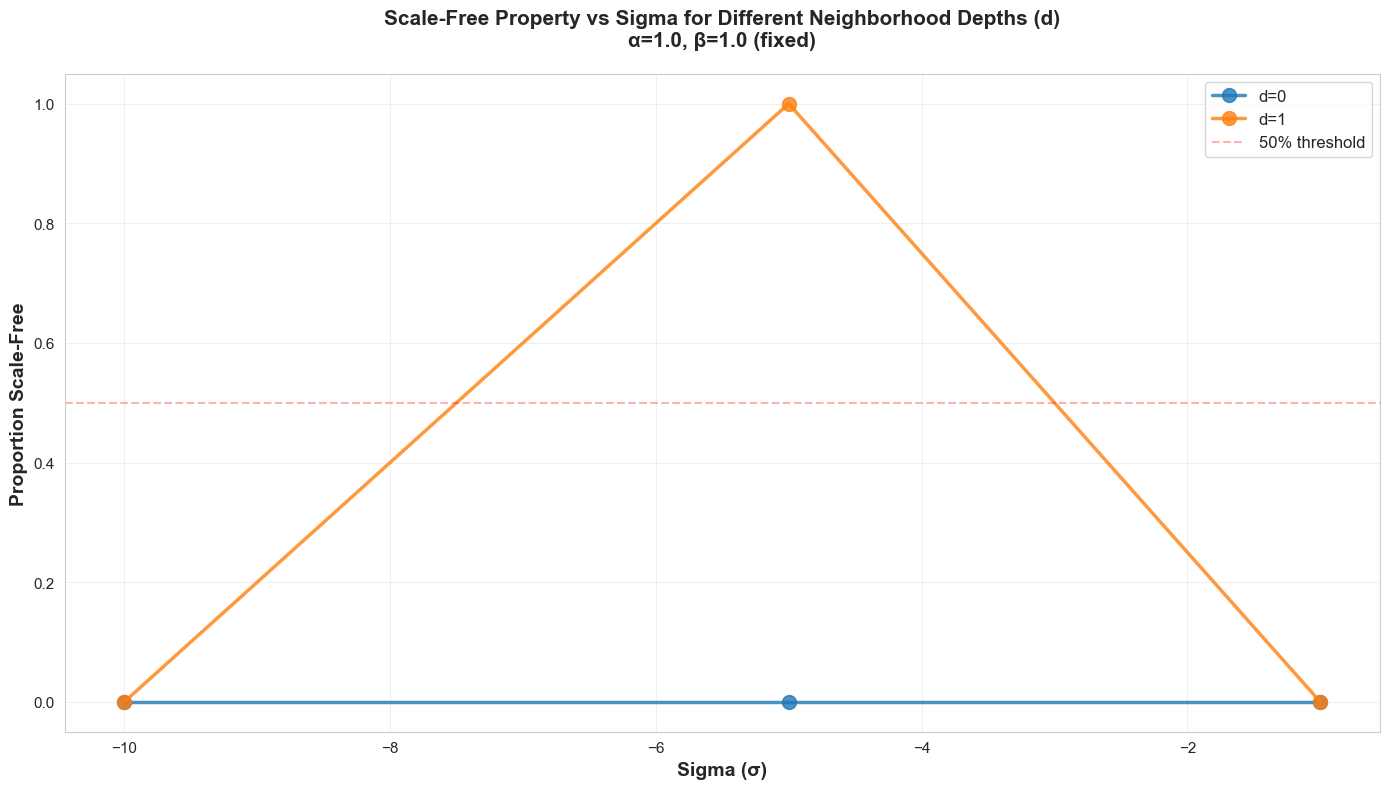


Scale-Free Statistics by d:

d=0:
  Overall proportion scale-free: 0.00%
  Max proportion: 0.00%
  Sigma values with scale-free > 50%: []

d=1:
  Overall proportion scale-free: 33.33%
  Max proportion: 100.00%
  Sigma values with scale-free > 50%: [-5]


In [38]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Plot for each d value
for d in sorted(agg_results['d'].unique()):
    d_data = agg_results[agg_results['d'] == d]
    ax.plot(
        d_data['sigma'],
        d_data['is_scale_free_mean'],
        marker='o',
        label=f'd={d}',
        linewidth=2.5,
        markersize=10,
        alpha=0.8
    )

ax.set_xlabel('Sigma (σ)', fontsize=14, fontweight='bold')
ax.set_ylabel('Proportion Scale-Free', fontsize=14, fontweight='bold')
ax.set_title('Scale-Free Property vs Sigma for Different Neighborhood Depths (d)\nα=1.0, β=1.0 (fixed)', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_ylim(-0.05, 1.05)
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.3, label='50% threshold')
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3)
ax.tick_params(labelsize=11)

plt.tight_layout()
plt.savefig('scale_free_vs_sigma.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print("\nScale-Free Statistics by d:")
for d in sorted(agg_results['d'].unique()):
    d_data = agg_results[agg_results['d'] == d]
    print(f"\nd={d}:")
    print(f"  Overall proportion scale-free: {d_data['is_scale_free_mean'].mean():.2%}")
    print(f"  Max proportion: {d_data['is_scale_free_mean'].max():.2%}")
    print(f"  Sigma values with scale-free > 50%: {list(d_data[d_data['is_scale_free_mean'] > 0.5]['sigma'].values)}")

### Plot 3: Power-Law Exponent vs. Sigma

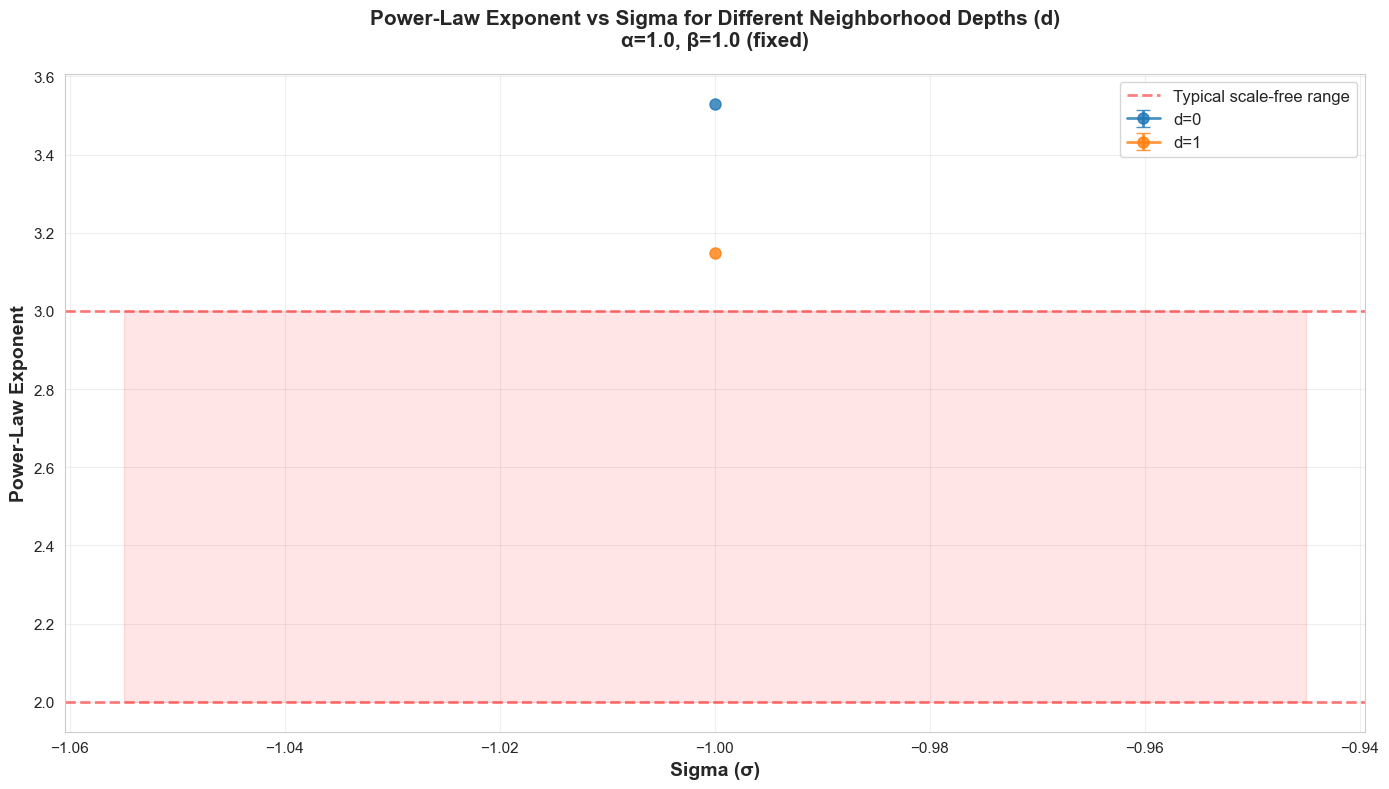

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Plot for each d value
for d in sorted(agg_results['d'].unique()):
    d_data = agg_results[agg_results['d'] == d]
    # Filter out NaN values
    valid_mask = ~np.isnan(d_data['power_law_alpha_mean'])
    d_data_valid = d_data[valid_mask]
    
    if len(d_data_valid) > 0:
        ax.errorbar(
            d_data_valid['sigma'],
            d_data_valid['power_law_alpha_mean'],
            yerr=d_data_valid['power_law_alpha_std'],
            marker='o',
            label=f'd={d}',
            capsize=5,
            alpha=0.8,
            linewidth=2,
            markersize=8
        )

# Add reference lines for typical scale-free range (2-3)
ax.axhline(y=2.0, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Typical scale-free range')
ax.axhline(y=3.0, color='red', linestyle='--', alpha=0.5, linewidth=2)
ax.fill_between(ax.get_xlim(), 2.0, 3.0, alpha=0.1, color='red')

ax.set_xlabel('Sigma (σ)', fontsize=14, fontweight='bold')
ax.set_ylabel('Power-Law Exponent', fontsize=14, fontweight='bold')
ax.set_title('Power-Law Exponent vs Sigma for Different Neighborhood Depths (d)\nα=1.0, β=1.0 (fixed)', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3)
ax.tick_params(labelsize=11)

plt.tight_layout()
plt.savefig('power_law_exponent_vs_sigma.png', dpi=300, bbox_inches='tight')
plt.show()

### Plot 4: 2D Heatmap - Clustering vs Scale-Free Property

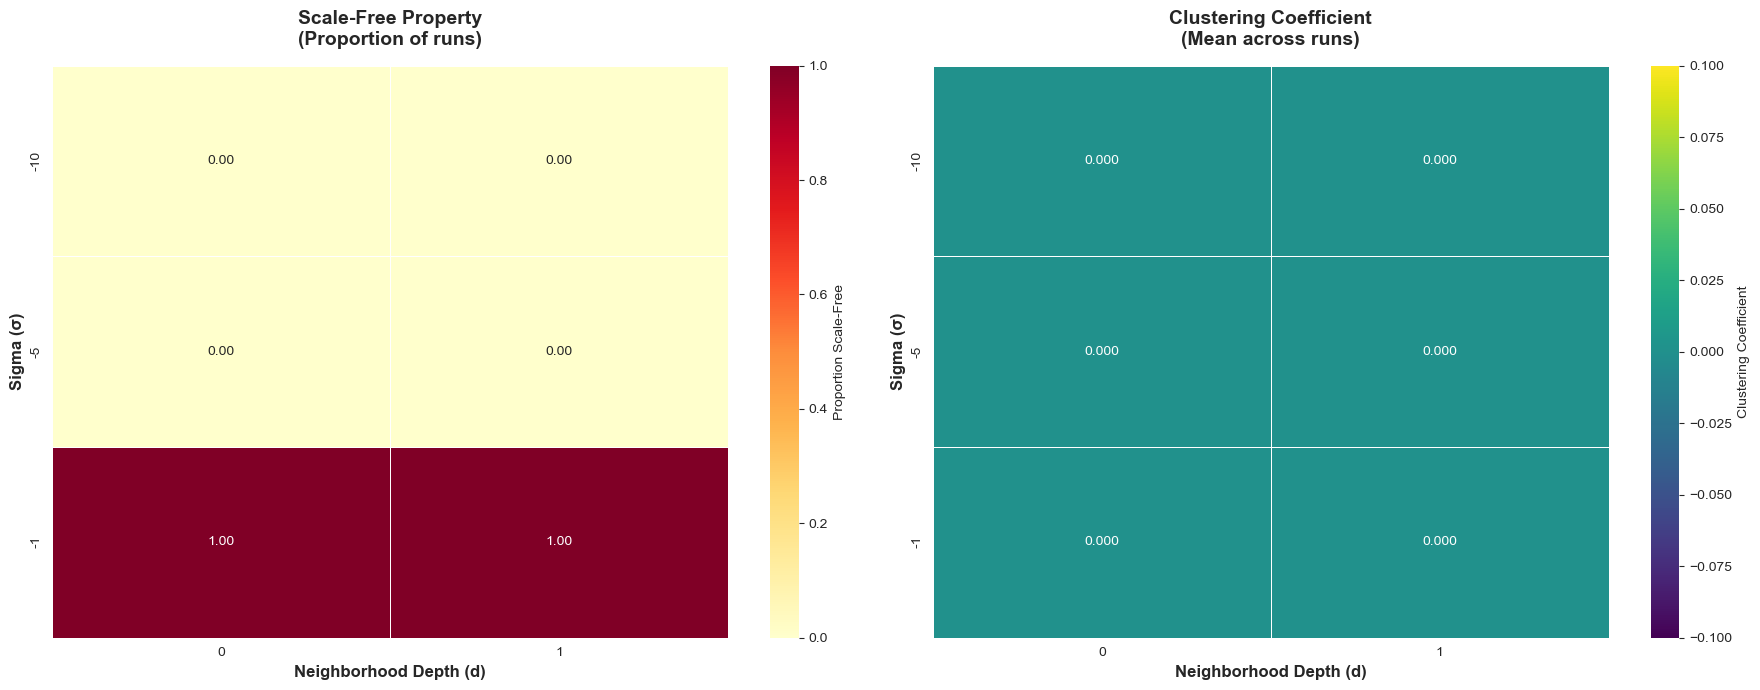

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Create pivot tables for heatmaps
pivot_scale_free = agg_results.pivot_table(
    values='is_scale_free_mean',
    index='sigma',
    columns='d',
    aggfunc='mean'
)

pivot_clustering = agg_results.pivot_table(
    values='clustering_coefficient_mean',
    index='sigma',
    columns='d',
    aggfunc='mean'
)

# Scale-Free heatmap
sns.heatmap(
    pivot_scale_free,
    annot=True,
    fmt='.2f',
    cmap='YlOrRd',
    cbar_kws={'label': 'Proportion Scale-Free'},
    ax=ax1,
    vmin=0,
    vmax=1,
    linewidths=0.5
)
ax1.set_title('Scale-Free Property\n(Proportion of runs)', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Neighborhood Depth (d)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Sigma (σ)', fontsize=12, fontweight='bold')

# Clustering heatmap
sns.heatmap(
    pivot_clustering,
    annot=True,
    fmt='.3f',
    cmap='viridis',
    cbar_kws={'label': 'Clustering Coefficient'},
    ax=ax2,
    linewidths=0.5
)
ax2.set_title('Clustering Coefficient\n(Mean across runs)', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Neighborhood Depth (d)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Sigma (σ)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('heatmap_sigma_d_properties.png', dpi=300, bbox_inches='tight')
plt.show()

### Plot 5: Clustering vs KS Statistic (Goodness of Power-Law Fit)

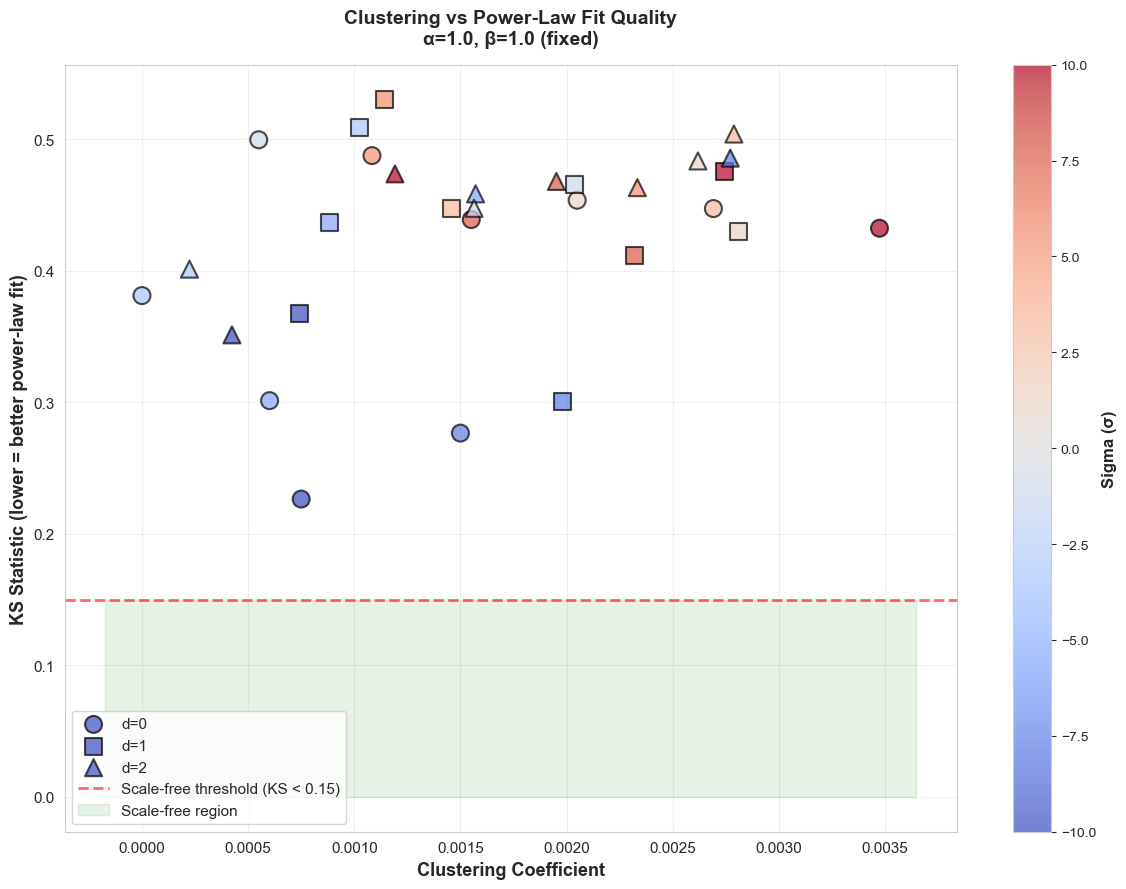


No configurations found with both high clustering and good power-law fit.


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

# Filter valid data
valid_mask = ~np.isnan(agg_results['ks_statistic_mean']) & ~np.isnan(agg_results['clustering_coefficient_mean'])
valid_data = agg_results[valid_mask]

# Create scatter plot for each d value with sigma as color
colors_map = {0: 'blue', 1: 'orange', 2: 'green'}
for d in sorted(valid_data['d'].unique()):
    d_data = valid_data[valid_data['d'] == d]
    scatter = ax.scatter(
        d_data['clustering_coefficient_mean'],
        d_data['ks_statistic_mean'],
        c=d_data['sigma'],
        s=150,
        alpha=0.7,
        cmap='coolwarm',
        label=f'd={d}',
        edgecolors='black',
        linewidth=1.5,
        marker=['o', 's', '^'][d]  # Different markers for each d
    )

# Add threshold line for scale-free criterion
ax.axhline(y=0.15, color='red', linestyle='--', linewidth=2, alpha=0.6, 
           label='Scale-free threshold (KS < 0.15)')
ax.fill_between(ax.get_xlim(), 0, 0.15, alpha=0.1, color='green', label='Scale-free region')

ax.set_xlabel('Clustering Coefficient', fontsize=13, fontweight='bold')
ax.set_ylabel('KS Statistic (lower = better power-law fit)', fontsize=13, fontweight='bold')
ax.set_title('Clustering vs Power-Law Fit Quality\nα=1.0, β=1.0 (fixed)', 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.tick_params(labelsize=11)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Sigma (σ)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('clustering_vs_ks_statistic.png', dpi=300, bbox_inches='tight')
plt.show()

# Print configurations in the "sweet spot" (high clustering, low KS)
sweet_spot = valid_data[(valid_data['clustering_coefficient_mean'] > valid_data['clustering_coefficient_mean'].quantile(0.75)) &
                        (valid_data['ks_statistic_mean'] < 0.15)]
if len(sweet_spot) > 0:
    print("\nConfigurations with HIGH clustering AND good power-law fit:")
    print(sweet_spot[['sigma', 'd', 'clustering_coefficient_mean', 'ks_statistic_mean', 'is_scale_free_mean']].to_string(index=False))
else:
    print("\nNo configurations found with both high clustering and good power-law fit.")

### Statistical Summary

In [ ]:
# Find parameter combinations that produce high clustering AND scale-free properties
high_clustering_threshold = agg_results['clustering_coefficient_mean'].quantile(0.75)
scale_free_threshold = 0.5  # At least 50% of runs should be scale-free

interesting_configs = agg_results[
    (agg_results['clustering_coefficient_mean'] > high_clustering_threshold) &
    (agg_results['is_scale_free_mean'] > scale_free_threshold)
].sort_values('clustering_coefficient_mean', ascending=False)

print("=" * 80)
print("PARAMETER COMBINATIONS WITH HIGH CLUSTERING AND SCALE-FREE PROPERTIES")
print("=" * 80)
print(f"\nCriteria:")
print(f"  - Clustering > {high_clustering_threshold:.4f} (75th percentile)")
print(f"  - Scale-Free Proportion > {scale_free_threshold}")
print(f"\nFound {len(interesting_configs)} configurations:\n")

if len(interesting_configs) > 0:
    display_cols = ['sigma', 'd', 'clustering_coefficient_mean', 'clustering_coefficient_std',
                    'is_scale_free_mean', 'power_law_alpha_mean', 'avg_degree_mean']
    print(interesting_configs[display_cols].to_string(index=False))
else:
    print("No configurations found meeting both criteria.")
    print("\n" + "="*80)
    print("TRYING RELAXED CRITERIA")
    print("="*80)
    
    # Relaxed thresholds
    relaxed_clustering = agg_results['clustering_coefficient_mean'].quantile(0.5)
    relaxed_scale_free = 0.3
    
    relaxed_configs = agg_results[
        (agg_results['clustering_coefficient_mean'] > relaxed_clustering) &
        (agg_results['is_scale_free_mean'] > relaxed_scale_free)
    ].sort_values('clustering_coefficient_mean', ascending=False)
    
    print(f"\nRelaxed criteria:")
    print(f"  - Clustering > {relaxed_clustering:.4f} (50th percentile)")
    print(f"  - Scale-Free > {relaxed_scale_free}")
    print(f"\nFound {len(relaxed_configs)} configurations:\n")
    
    if len(relaxed_configs) > 0:
        print(relaxed_configs[display_cols].head(10).to_string(index=False))

# Find best configurations for each property separately
print("\n" + "="*80)
print("TOP 5 CONFIGURATIONS BY CLUSTERING COEFFICIENT")
print("="*80)
top_clustering = agg_results.nlargest(5, 'clustering_coefficient_mean')
print(top_clustering[['sigma', 'd', 'clustering_coefficient_mean', 'is_scale_free_mean', 
                      'avg_degree_mean']].to_string(index=False))

print("\n" + "="*80)
print("TOP 5 CONFIGURATIONS BY SCALE-FREE PROPERTY")
print("="*80)
top_scale_free = agg_results.nlargest(5, 'is_scale_free_mean')
print(top_scale_free[['sigma', 'd', 'is_scale_free_mean', 'clustering_coefficient_mean',
                      'power_law_alpha_mean', 'ks_statistic_mean']].to_string(index=False))

PARAMETER COMBINATIONS WITH HIGH CLUSTERING AND SCALE-FREE PROPERTIES

Criteria:
  - Clustering > 0.0023 (75th percentile)
  - Scale-Free Proportion > 0.5

Found 0 configurations:

No configurations found meeting both criteria.

TRYING RELAXED CRITERIA

Relaxed criteria:
  - Clustering > 0.0016 (50th percentile)
  - Scale-Free > 0.3

Found 0 configurations:


TOP 5 CONFIGURATIONS BY CLUSTERING COEFFICIENT
    sigma  d  clustering_coefficient_mean  is_scale_free_mean  avg_degree_mean
10.000000  0                     0.003474                 0.0            2.608
 1.111111  1                     0.002810                 0.0            2.589
 3.333333  2                     0.002788                 0.0            2.616
-7.777778  2                     0.002771                 0.0            1.991
10.000000  1                     0.002745                 0.0            2.608

TOP 5 CONFIGURATIONS BY SCALE-FREE PROPERTY
     sigma  d  is_scale_free_mean  clustering_coefficient_mean  power_la

### Correlation Analysis

In [ ]:
# Correlation between parameters and properties
correlation_vars = ['sigma', 'd', 'clustering_coefficient_mean', 
                    'is_scale_free_mean', 'power_law_alpha_mean', 
                    'avg_degree_mean', 'density_mean', 'max_degree_mean']

corr_data = agg_results[correlation_vars].copy()
corr_matrix = corr_data.corr()

plt.figure(figsize=(11, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            fmt='.3f', annot_kws={'size': 10})
plt.title('Correlation Matrix: Parameters vs Network Properties\nα=1.0, β=1.0 (fixed)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("KEY CORRELATIONS WITH CLUSTERING COEFFICIENT")
print("="*80)
clustering_corr = corr_matrix['clustering_coefficient_mean'].sort_values(ascending=False)
for var, corr in clustering_corr.items():
    if var != 'clustering_coefficient_mean':
        print(f"{var:30s}: {corr:+.3f}")

print("\n" + "="*80)
print("KEY CORRELATIONS WITH SCALE-FREE PROPERTY")
print("="*80)
scale_free_corr = corr_matrix['is_scale_free_mean'].sort_values(ascending=False)
for var, corr in scale_free_corr.items():
    if var != 'is_scale_free_mean':
        print(f"{var:30s}: {corr:+.3f}")

KeyError: "['max_degree_mean'] not in index"

## Visualize Example Graphs

Let's generate and visualize a few example graphs with interesting properties.

In [ ]:
def visualize_graph_with_properties(G, title, ax=None):
    """Visualize a graph with its degree distribution."""
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Calculate properties
    props = analyze_graph_properties(G)
    
    # Use spring layout
    pos = nx.spring_layout(G, seed=42, k=0.5, iterations=50)
    
    # Color nodes by degree
    degrees = dict(G.degree())
    node_colors = [degrees[node] for node in G.nodes()]
    
    # Draw graph
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=50, 
                          cmap='plasma', ax=ax, alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.15, ax=ax, width=0.3)
    
    # Add title with properties
    title_text = f"{title}\n"
    title_text += f"Clustering: {props['clustering_coefficient']:.3f} | "
    title_text += f"Scale-free: {props['is_scale_free']} | "
    title_text += f"Power-law α: {props['power_law_alpha']:.2f}\n"
    title_text += f"Nodes: {props['n_nodes']} | Edges: {props['n_edges']} | "
    title_text += f"Avg Degree: {props['avg_degree']:.1f}"
    
    ax.set_title(title_text, fontsize=9)
    ax.axis('off')
    
    return props


def plot_degree_distribution(G, ax, title=""):
    """Plot degree distribution on log-log scale."""
    degrees = [d for n, d in G.degree() if d > 0]
    
    if len(degrees) < 2:
        ax.text(0.5, 0.5, 'Insufficient data', ha='center', va='center')
        return
    
    degree_counts = np.bincount(degrees)
    non_zero_degrees = np.where(degree_counts > 0)[0]
    
    if len(non_zero_degrees) < 2:
        ax.text(0.5, 0.5, 'Insufficient data', ha='center', va='center')
        return
    
    x = non_zero_degrees
    y = degree_counts[non_zero_degrees]
    
    # Plot on log-log scale
    ax.loglog(x, y, 'o', alpha=0.7, markersize=10, color='steelblue')
    
    # Fit and plot power law
    log_x = np.log(x)
    log_y = np.log(y)
    slope, intercept = np.polyfit(log_x, log_y, 1)
    
    fit_y = np.exp(intercept) * x ** slope
    ax.loglog(x, fit_y, '--', alpha=0.7, linewidth=2, color='red',
              label=f'Power-law fit (α={-slope:.2f})')
    
    ax.set_xlabel('Degree (k)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency P(k)', fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, which='both')


# Select interesting parameter combinations
# Get one from each extreme region
example_configs = [
    {'sigma': -10.0, 'd': 0, 'label': 'Low σ, d=0'},
    {'sigma': 0.0, 'd': 1, 'label': 'Mid σ, d=1'},
    {'sigma': 10.0, 'd': 2, 'label': 'High σ, d=2'},
]

# Add best clustering and best scale-free if different
best_clust = agg_results.nlargest(1, 'clustering_coefficient_mean').iloc[0]
example_configs.append({
    'sigma': best_clust['sigma'], 
    'd': int(best_clust['d']), 
    'label': 'Best Clustering'
})

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(len(example_configs), 4, hspace=0.4, wspace=0.4)

for i, config in enumerate(example_configs):
    print(f"\nGenerating example graph {i+1}: {config['label']} (σ={config['sigma']}, d={config['d']})")
    
    # Generate graph
    sim = simulation.LogitGraphSimulation(
        n=500,
        d=config['d'],
        sigma=config['sigma'],
        alpha=1.0,
        beta=1.0,
        er_p=0.05,
        n_iteration=5000,
        patience=1000,
        verbose=False
    )
    sim.simulate()
    
    if sim.simulated_graph is not None:
        # Graph visualization
        ax1 = fig.add_subplot(gs[i, :2])
        props = visualize_graph_with_properties(
            sim.simulated_graph,
            f"{config['label']}: σ={config['sigma']:.1f}, d={config['d']}",
            ax=ax1
        )
        
        # Degree distribution
        ax2 = fig.add_subplot(gs[i, 2:])
        plot_degree_distribution(sim.simulated_graph, ax2, f"Degree Distribution - {config['label']}")

plt.savefig('example_graphs.png', dpi=300, bbox_inches='tight')
plt.show()